<a href="https://colab.research.google.com/github/Manish-k723/Web-App/blob/main/Message_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet

In [2]:
import opendatasets as od
import numpy as np
import pandas as pd
import os

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/code?select=spam.csv'

In [4]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: manishkumar7432698
Your Kaggle Key: ··········


100%|██████████| 211k/211k [00:00<00:00, 26.5MB/s]

In [5]:
datadir = os.listdir('/content/sms-spam-collection-dataset')
datadir

['spam.csv']

In [6]:
df = pd.read_csv('/content/sms-spam-collection-dataset/spam.csv', encoding = 'ISO-8859-1')
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['label','message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

We have 4825 ham message and 747 spam message

## **Data Ckeaning && Feature Engineering**

Checking for duplicate values

In [9]:
df.duplicated().sum()

403

In [11]:
df = df.drop_duplicates(keep = 'first')

In [12]:
df['target'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,message,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
# df.rename(columns = {'label_num' : 'target'},inplace = True)

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general.

In [15]:
df['message_len'] = df.message.apply(len)
df.head()

,label,message,target,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


In [ ]:
import nltk
nltk.download('punkt')
df['words'] = df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
df['sentence'] = df['message'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [ ]:
df

## **Visualization**

In [16]:
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

Text(0.5, 0, 'Message Length')

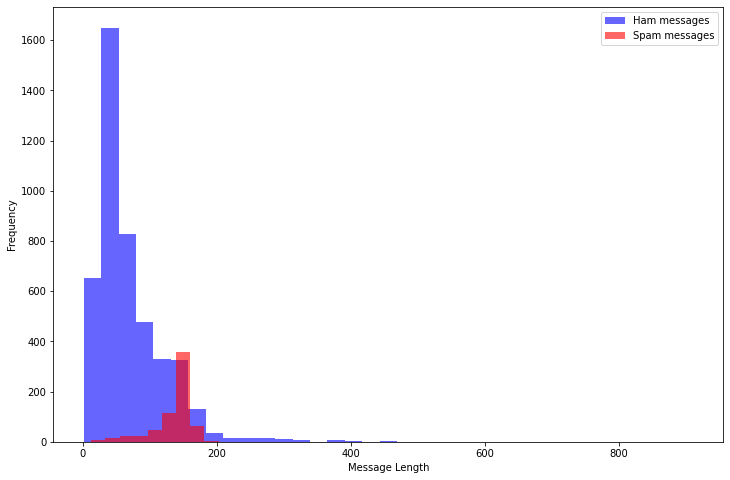

In [17]:
plt.figure(figsize=(12, 8))

df[df.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
df[df.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

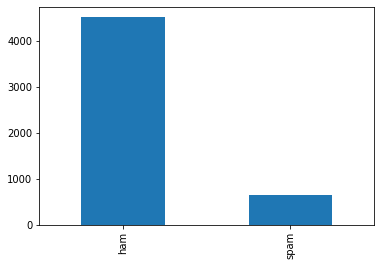

In [18]:
df.label.value_counts().plot(kind = 'bar')

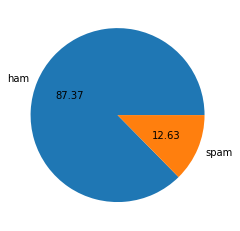

In [22]:
plt.pie(df['target'].value_counts(),labels = ['ham','spam'],autopct = '%0.2f')
plt.show()

Around 88% messages are from spam category which is not good for model but this is real life data and we have to work with that.

In [ ]:
df[df.label== 'ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.023627
std,0.0,58.016023
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,92.000000
max,0.0,910.000000


Wo hoo! Max length message is of 910 characters

In [ ]:
df[df.label== 'spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,138.866131
std,0.0,29.183082
min,1.0,13.000000
25%,1.0,132.500000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,224.000000


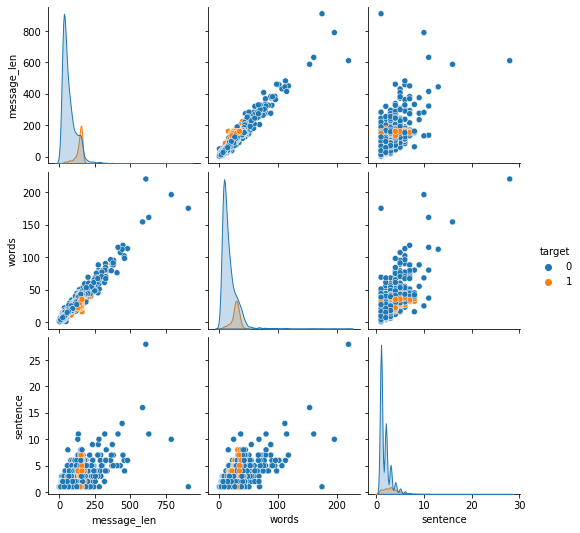

In [36]:
sns.pairplot(df,hue = 'target')

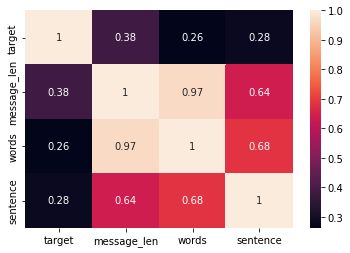

In [38]:
sns.heatmap(df.corr(),annot = True)

We will not use all the three columns i.e. message_len, words, sentence because they have a strong relation with each other and they may affect our prediction.

## **Preprocessing**
Our main issue with our data is that it is all in text format (strings). The classification algorithms that we usally use need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the bag-of-words approach, where each unique word in a text will be represented by one number.

In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use apply() in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in string library to get a quick list of all the possible punctuation:

## **Data Preprocessing**

What thinks to do in it 


1.   Convert to lower case
2.   Tokenization
3.   Removing special characters
4.   Removing punctuation and stop words.
5.   Stemming - Convert similar words into one word.





In [ ]:
from nltk.corpus import stopwords
nltk.download ('stopwords')
stopwords.words('english')

In [39]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [45]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [49]:
def text_transform(text):
  y = []
  text = text.lower() # 1st step
  text = nltk.word_tokenize(text) # 2nd step
  for i in text:# 3 step
      if i.isalnum():
        y.append(i)
  text = y[:]
  y.clear()
  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      y.append(i)
  text = y[:]
  y.clear()
  for i in text:
    y.append(ps.stem(i))
  text = y[:]
  return " ".join(text)

In [51]:
df.message[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [50]:
text_transform(df.message[0])

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

In [54]:
df['transformed_text'] = df['message'].apply(text_transform)

In [56]:
df

,label,message,target,message_len,words,sentence,transformed_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,0,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,0,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1,nah think goe usf live around though
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,161,35,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,ham,Will Ì_ b going to esplanade fr home?,0,37,9,1,b go esplanad fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",0,57,15,2,piti mood suggest
5570,ham,The guy did some bitching but I acted like i'd...,0,125,27,1,guy bitch act like interest buy someth els nex...


Now, I will make a word cloud for spams and hams which shows the most common words of both category in size varying bubble.

In [81]:
from wordcloud import WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white',collocations = False)

In [82]:
spam_wc = wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep = ' '))

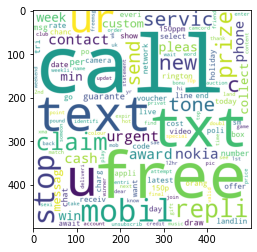

In [83]:
plt.imshow(spam_wc)

This cell will create a word cloud object of spam which have data of transformed text column.

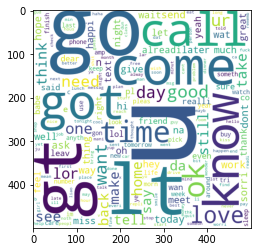

In [85]:
ham_wc = wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep = ' '))
plt.imshow(ham_wc)

Let's verify word cloud by extracting top 30 or 50 most common words from spam messages.

In [74]:
spam_corpus = []
for msg in df[df['target']==1]['transformed_text']:
  for word in msg.split():
    spam_corpus.append(word)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


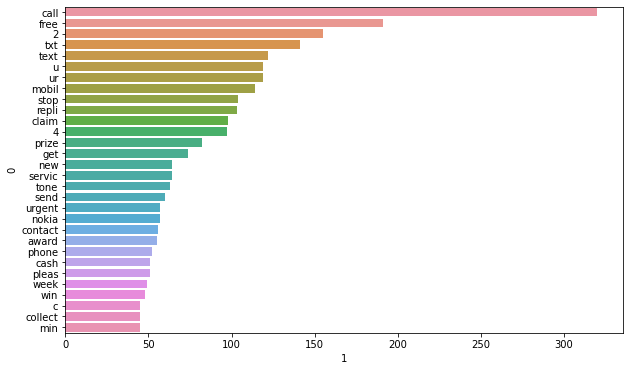

In [80]:
plt.figure(figsize = (10,6))
from collections import Counter
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[1],pd.DataFrame(Counter(spam_corpus).most_common(30))[0])
# plt.xticks(rotation = 'vertical')
plt.show()

In [86]:
ham_corpus = []
for msg in df[df['target']==0]['transformed_text']:
  for word in msg.split():
    ham_corpus.append(word)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


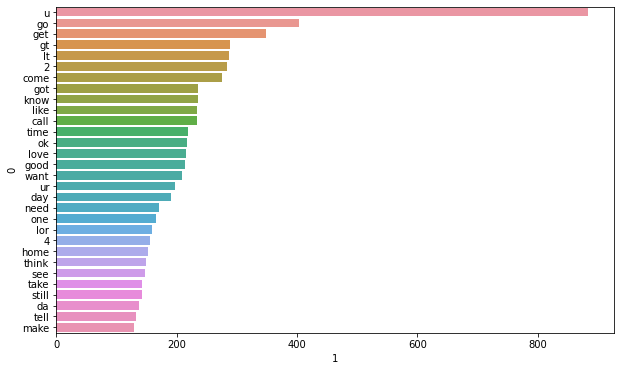

In [87]:
plt.figure(figsize = (10,6))
from collections import Counter
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[1],pd.DataFrame(Counter(ham_corpus).most_common(30))[0])
# plt.xticks(rotation = 'vertical')
plt.show()

## **Modelling**
We will firstly create bag of words and after this we will apply Naive Bayes because it is believed that Naive Bayes works so well with textual data.

In [132]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features = 3000)

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

In [ ]:
# appending the num_character col to X
#X = np.hstack((X,df['num_characters'].values.reshape(-1,1)))

In [133]:
X = cv.fit_transform(df['transformed_text']).toarray()

In [134]:
X.shape

(5169, 6708)

In [135]:
y = df['target'].values

In [136]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [137]:
from sklearn.model_selection import train_test_split

In [138]:
x_train, x_test,y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

We are using precision score here with accuracy_score because here precision_score is more reliable feature than accuracy_score. The data which we have is imbalanced. The more data is of ham.

In [139]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

Because I don't know about the distribution of the data and this is the reason why I am import three different naive bayes methos

In [140]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [141]:
gnb.fit(x_train,y_train)
pred1 = gnb.predict(x_test)
print(accuracy_score(y_test,pred1))
print(confusion_matrix(y_test, pred1))
print(precision_score(y_test,pred1))

0.8684719535783365
[[772 117]
 [ 19 126]]
0.5185185185185185


Performance of Gaussian Naive is very bad. Only precision of 51%

In [142]:
mnb.fit(x_train,y_train)
pred2 = mnb.predict(x_test)
print(accuracy_score(y_test,pred2))
print(confusion_matrix(y_test, pred2))
print(precision_score(y_test,pred2))

0.9738878143133463
[[872  17]
 [ 10 135]]
0.8881578947368421


Decent Performance and Far better than Gaussian

In [143]:
bnb.fit(x_train,y_train)
pred3 = bnb.predict(x_test)
print(accuracy_score(y_test,pred3))
print(confusion_matrix(y_test, pred3))
print(precision_score(y_test,pred3))

0.9661508704061895
[[885   4]
 [ 31 114]]
0.9661016949152542


The precision score is too good.

Modelling on TFIDF Vectorizer

In [144]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [145]:
x_train, x_test,y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [146]:
gnb.fit(x_train,y_train)
pred1 = gnb.predict(x_test)
print(accuracy_score(y_test,pred1))
print(confusion_matrix(y_test, pred1))
print(precision_score(y_test,pred1))

0.8607350096711799
[[769 120]
 [ 24 121]]
0.5020746887966805


In [147]:
mnb.fit(x_train,y_train)
pred2 = mnb.predict(x_test)
print(accuracy_score(y_test,pred2))
print(confusion_matrix(y_test, pred2))
print(precision_score(y_test,pred2))

0.9729206963249516
[[888   1]
 [ 27 118]]
0.9915966386554622


In [148]:
bnb.fit(x_train,y_train)
pred3 = bnb.predict(x_test)
print(accuracy_score(y_test,pred3))
print(confusion_matrix(y_test, pred3))
print(precision_score(y_test,pred3))

0.9729206963249516
[[884   5]
 [ 23 122]]
0.9606299212598425


So, from all of the modelling we can conclude for now that Model with Multinomial NaiveBayes and Tdidf vectorizer will be the right fit for this data.

## **Model Comparision**

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [150]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [151]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [152]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [153]:
train_classifier(svc,x_train,y_train,x_test,y_test)

(0.97678916827853, 0.9548872180451128)

In [154]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, x_train,y_train,x_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.97678916827853
Precision -  0.9548872180451128
For  KN
Accuracy -  0.9100580270793037
Precision -  1.0
For  NB
Accuracy -  0.9729206963249516
Precision -  0.9915966386554622
For  DT
Accuracy -  0.9332688588007737
Precision -  0.8333333333333334
For  LR
Accuracy -  0.9468085106382979
Precision -  0.8688524590163934
For  RF
Accuracy -  0.9738878143133463
Precision -  0.9836065573770492
For  AdaBoost
Accuracy -  0.9506769825918762
Precision -  0.8671875
For  BgC
Accuracy -  0.9613152804642167
Precision -  0.8832116788321168
For  ETC
Accuracy -  0.9777562862669246
Precision -  0.9841269841269841
For  GBDT
Accuracy -  0.9468085106382979
Precision -  0.95
For  xgb
Accuracy -  0.937137330754352
Precision -  0.9347826086956522


In [155]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [156]:
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.910058,1.000000
2,NB,0.972921,0.991597
8,ETC,0.977756,0.984127
5,RF,0.973888,0.983607
0,SVC,0.976789,0.954887
9,GBDT,0.946809,0.950000
10,xgb,0.937137,0.934783
7,BgC,0.961315,0.883212
4,LR,0.946809,0.868852
6,AdaBoost,0.950677,0.867188


In [157]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.910058
1,NB,Accuracy,0.972921
2,ETC,Accuracy,0.977756
3,RF,Accuracy,0.973888
4,SVC,Accuracy,0.976789
5,GBDT,Accuracy,0.946809
6,xgb,Accuracy,0.937137
7,BgC,Accuracy,0.961315
8,LR,Accuracy,0.946809
9,AdaBoost,Accuracy,0.950677


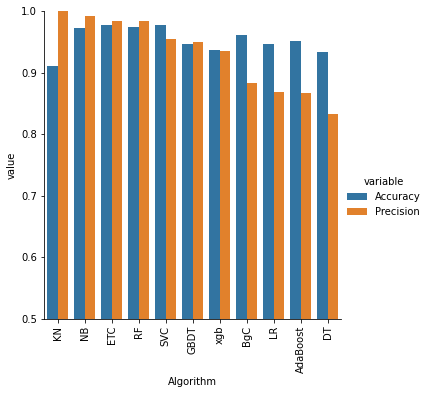

In [158]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [167]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft_3000':accuracy_scores,'Precision_max_ft_3000':precision_scores}).sort_values('Precision_max_ft_3000',ascending=False)

In [162]:
# temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores}).sort_values('Precision_scaling',ascending=False)

In [168]:
new_df = performance_df.merge(temp_df,on='Algorithm')

In [169]:
# new_df_scaled = new_df.merge(temp_df,on='Algorithm')

In [170]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores}).sort_values('Precision_num_chars',ascending=False)

In [171]:
new_df.merge(temp_df,on='Algorithm')

,Algorithm,Accuracy,Precision,Accuracy_max_ft_3000,Precision_max_ft_3000,Accuracy_num_chars,Precision_num_chars
0,KN,0.910058,1.000000,0.910058,1.000000,0.910058,1.000000
1,NB,0.972921,0.991597,0.972921,0.991597,0.972921,0.991597
2,ETC,0.977756,0.984127,0.977756,0.984127,0.977756,0.984127
3,RF,0.973888,0.983607,0.973888,0.983607,0.973888,0.983607
4,SVC,0.976789,0.954887,0.976789,0.954887,0.976789,0.954887
5,GBDT,0.946809,0.950000,0.946809,0.950000,0.946809,0.950000
6,xgb,0.937137,0.934783,0.937137,0.934783,0.937137,0.934783
7,BgC,0.961315,0.883212,0.961315,0.883212,0.961315,0.883212
8,LR,0.946809,0.868852,0.946809,0.868852,0.946809,0.868852
9,AdaBoost,0.950677,0.867188,0.950677,0.867188,0.950677,0.867188


One more thing which we can try is to scale down the features, but it is not be that much useful on this data. and for that reason I am commenting out that scaling part.

### **Voting Classifier**

In [172]:
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [173]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')
voting.fit(x_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [174]:
y_pred = voting.predict(x_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9816247582205029
Precision 0.9921875


### **Applying Stacking**

In [175]:
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [176]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
clf.fit(x_train,y_train)

StackingClassifier(estimators=[('svm',
                                SVC(gamma=1.0, kernel='sigmoid',
                                    probability=True)),
                               ('nb', MultinomialNB()),
                               ('et',
                                ExtraTreesClassifier(n_estimators=50,
                                                     random_state=2))],
                   final_estimator=RandomForestClassifier())

In [177]:
y_pred = clf.predict(x_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9825918762088974
Precision 0.9568345323741008


In [178]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))